# Part 6.1: Image Processing in Python

We will make use of images to demonstrate auto encoders.  To use images in Python, we will make use of the Pillow package. The following program uses Pillow to load and display an image.

[[[174 184 194]
  [173 183 193]
  [173 183 193]
  ...
  [  2  82 143]
  [  2  82 143]
  [  2  82 143]]

 [[174 184 194]
  [174 184 194]
  [173 183 193]
  ...
  [  2  82 143]
  [  2  82 143]
  [  2  82 143]]

 [[174 184 194]
  [174 184 194]
  [174 184 194]
  ...
  [  2  82 143]
  [  2  82 143]
  [  2  82 143]]

 ...

 [[ 80  79  87]
  [ 86  85  93]
  [ 89  88  96]
  ...
  [ 81  84  89]
  [ 90  93  98]
  [101 104 109]]

 [[ 96  95 103]
  [100  99 107]
  [101 100 108]
  ...
  [ 79  82  87]
  [ 84  87  92]
  [ 90  93  98]]

 [[107 106 114]
  [111 110 118]
  [112 111 119]
  ...
  [ 71  74  79]
  [ 71  74  79]
  [ 72  75  80]]]


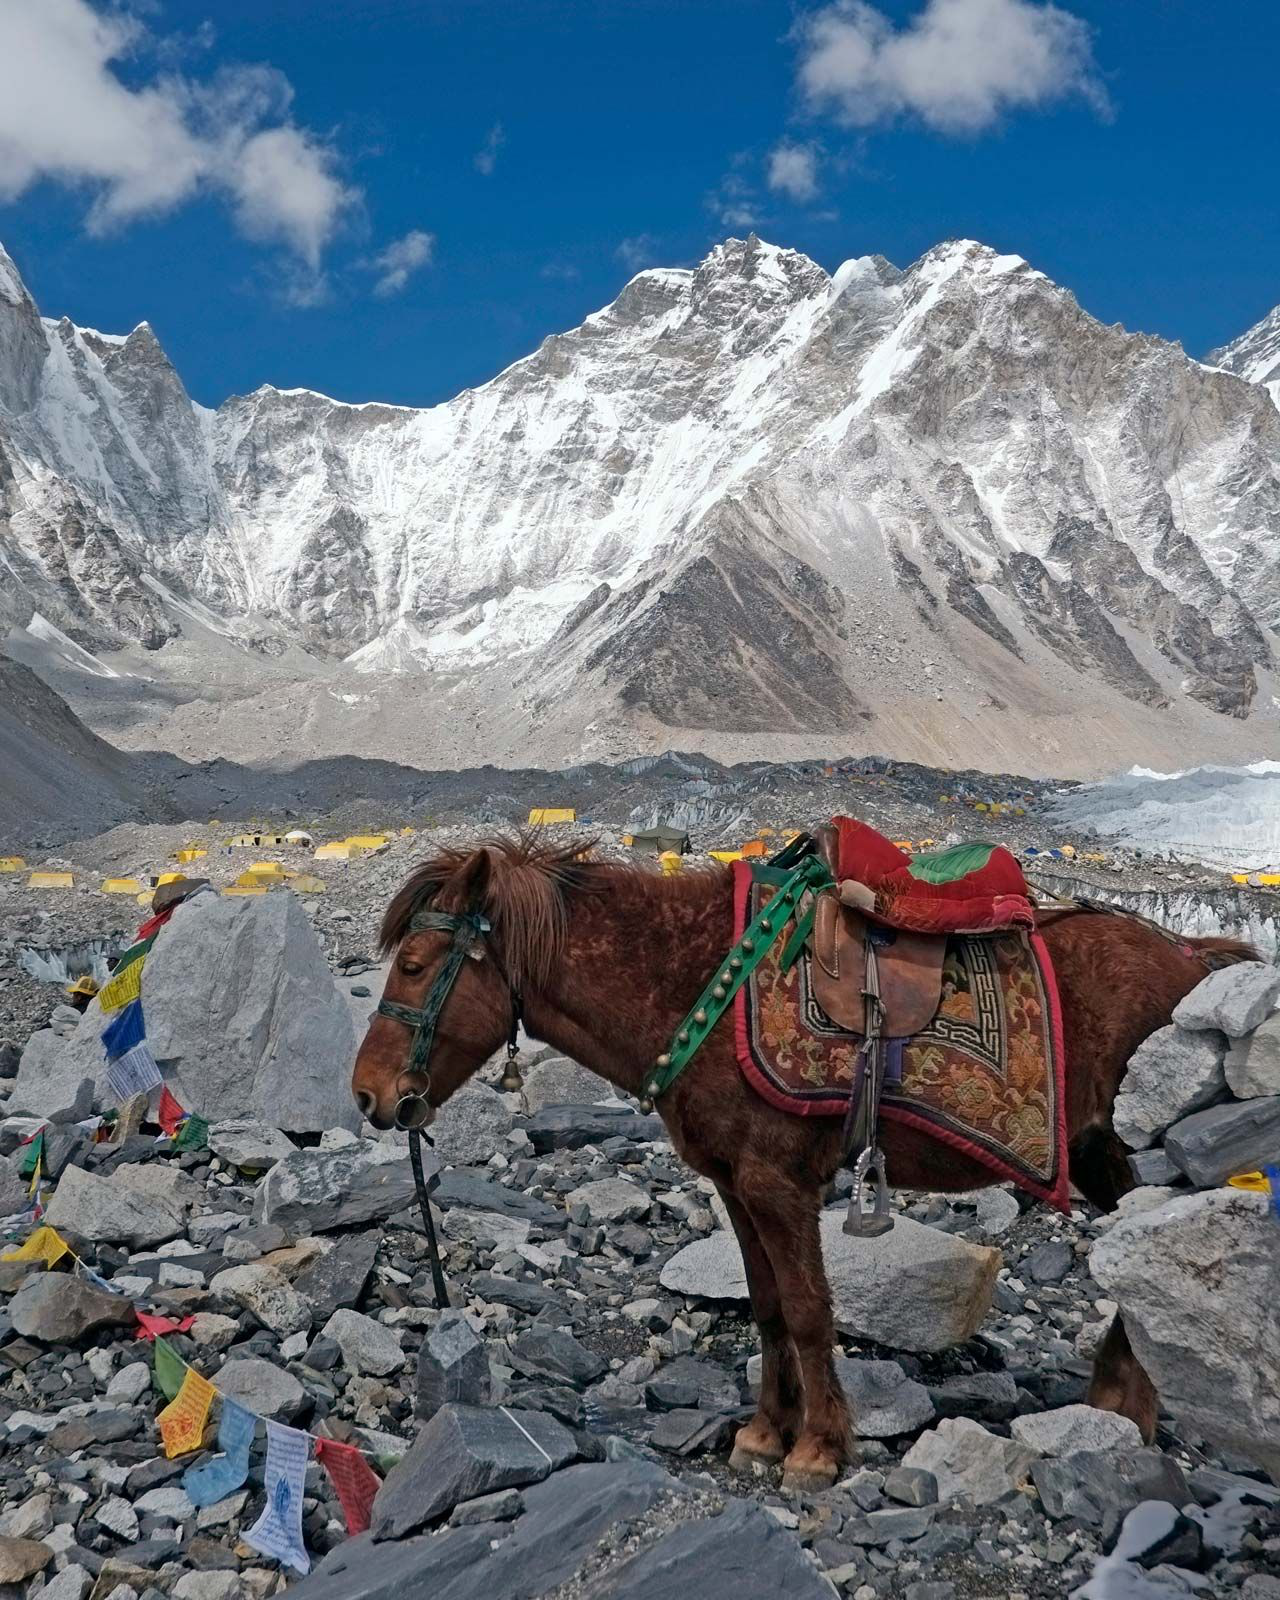

In [4]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
import numpy as np

%matplotlib inline

url = "https://cdn.britannica.com/15/179215-050-874E3420/Tents-background-landscape-Mount-Everest-Base-Camp.jpg"
response = requests.get(url, headers = "")
img = Image.open(BytesIO(response.content))
img.load()
print(np.asarray(img))

img

### Creating Images (from pixels) in Python

Pillow can also be used to create an image from a 3D numpy cube.  The rows and columns specify the pixels.  The depth, of 3, specifies red, green and blue.  Here a simple image is created.

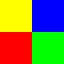

In [11]:
from PIL import Image
import numpy as np

# width height
w, h, channels = 64, 64, 3
# create and empty image
data = np.zeros((h, w, channels), dtype=np.uint8)

#Yellow
for row in range(32):
    for col in range(32):
        data[row,col] = [255,255,0]

#Red
for row in range(32):
    for col in range(32):
        data[row+32,col] = [255,0,0]
        

#Green
for row in range(32):
    for col in range(32):
        data[row+32,col+32] = [0,255,0]
        

#Blue
for row in range(32):
    for col in range(32):
        data[row,col+32] = [0,0,255]
        
img = Image.fromarray(data, 'RGB')
img

### Transform Images in Python (at the pixel level)

We can combine the last two programs and modify images.  Here we take the mean color of each pixel and form a grayscale image.

Rows : 1600, Cols : 1280


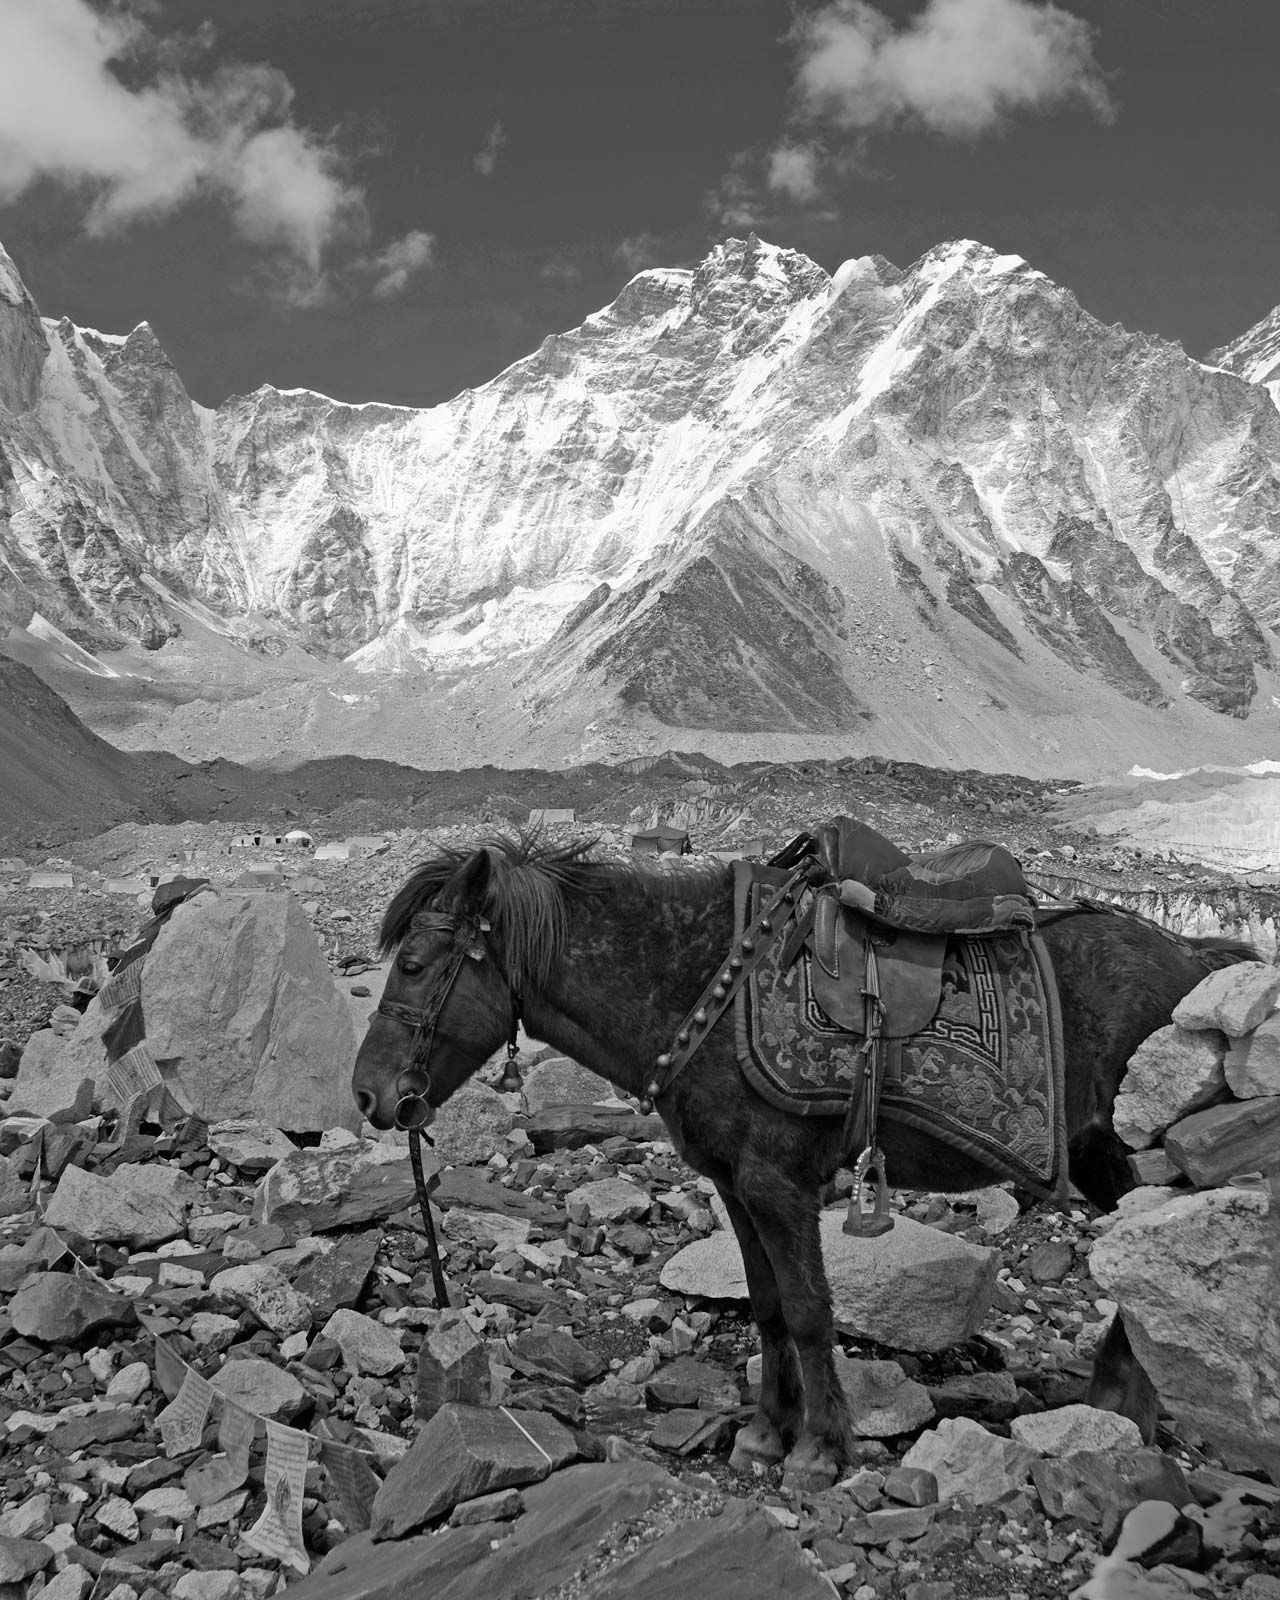

In [18]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO
%matplotlib inline
url = "https://cdn.britannica.com/15/179215-050-874E3420/Tents-background-landscape-Mount-Everest-Base-Camp.jpg"
response = requests.get(url, headers = "")
img = Image.open(BytesIO(response.content))
img.load()
img_array = np.asarray(img)
img_array
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows : {}, Cols : {}".format(rows,cols))

# Createing New Images
img2_array = np.zeros((rows, cols, 3), dtype = np.uint8)

for row in range(rows):
    for col in range(cols):
        t = np.mean(img_array[row,col])
        img2_array[row,col] = [t,t,t]
        
img2 = Image.fromarray(img2_array, 'RGB')
img2

# Standardize Images

When processing several images together it is sometimes important to standardize them.  The following code reads a sequence of images and causes them to all be of the same size and perfectly square.  If the input images are not square, cropping will occur.

https://cdn.britannica.com/33/178633-050-EDF93EA2/Taj-Mahal-Agra-Uttar-Pradesh-India.jpg


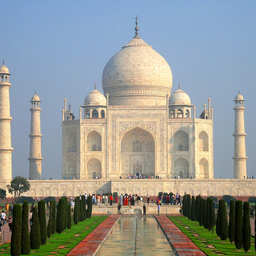

https://cdn.britannica.com/30/178930-050-A9761BDF/El-Castillo-Chichen-Itza-Yucatan-Mexico.jpg


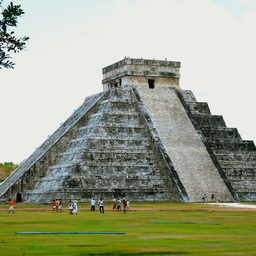

https://cdn.britannica.com/82/94382-050-20CF23DB/Great-Wall-of-China-Beijing.jpg


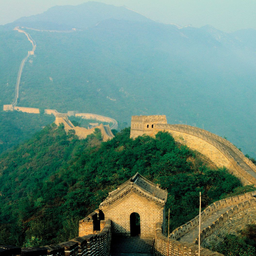

(3, 196608)


In [28]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
import numpy as np
from io import BytesIO
from IPython.display import display, HTML
%matplotlib inline

images = [
    "https://cdn.britannica.com/33/178633-050-EDF93EA2/Taj-Mahal-Agra-Uttar-Pradesh-India.jpg",
    "https://cdn.britannica.com/30/178930-050-A9761BDF/El-Castillo-Chichen-Itza-Yucatan-Mexico.jpg",
    "https://cdn.britannica.com/82/94382-050-20CF23DB/Great-Wall-of-China-Beijing.jpg"  
]

def crop_square(image):
    width, height = image.size
     # Crop the image centered
    new_width = min(width, height)
    new_height = new_width
    left = (width - new_width)/2
    top  = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2
    return image.crop((left, top, right, bottom))

x = []

for url in images:
    ImageFile.LOAD_TRUNCATED_IMAGES = False
    response = requests.get(url, headers = "")
    img = Image.open(BytesIO(response.content))
    img.load()
    img = crop_square(img)
    img = img.resize((256, 256), Image.ANTIALIAS)
    print(url)
    display(img)
    img_array = np.asarray(img)
    img_array = img_array.flatten()
    img_array = img_array.astype(np.float32)
    img_array = (img_array-128)/256
    x.append(img_array)

x = np.array(x)

print(x.shape)

### Adding Noise to an Image

Auto encoders can handle noise.  First it is important to see how to add noise to an image.  There are many ways to add such noise.  The following code adds random black squares to the image to produce noise.

Rows: 1200, Cols: 1600
(1200, 1600, 3)


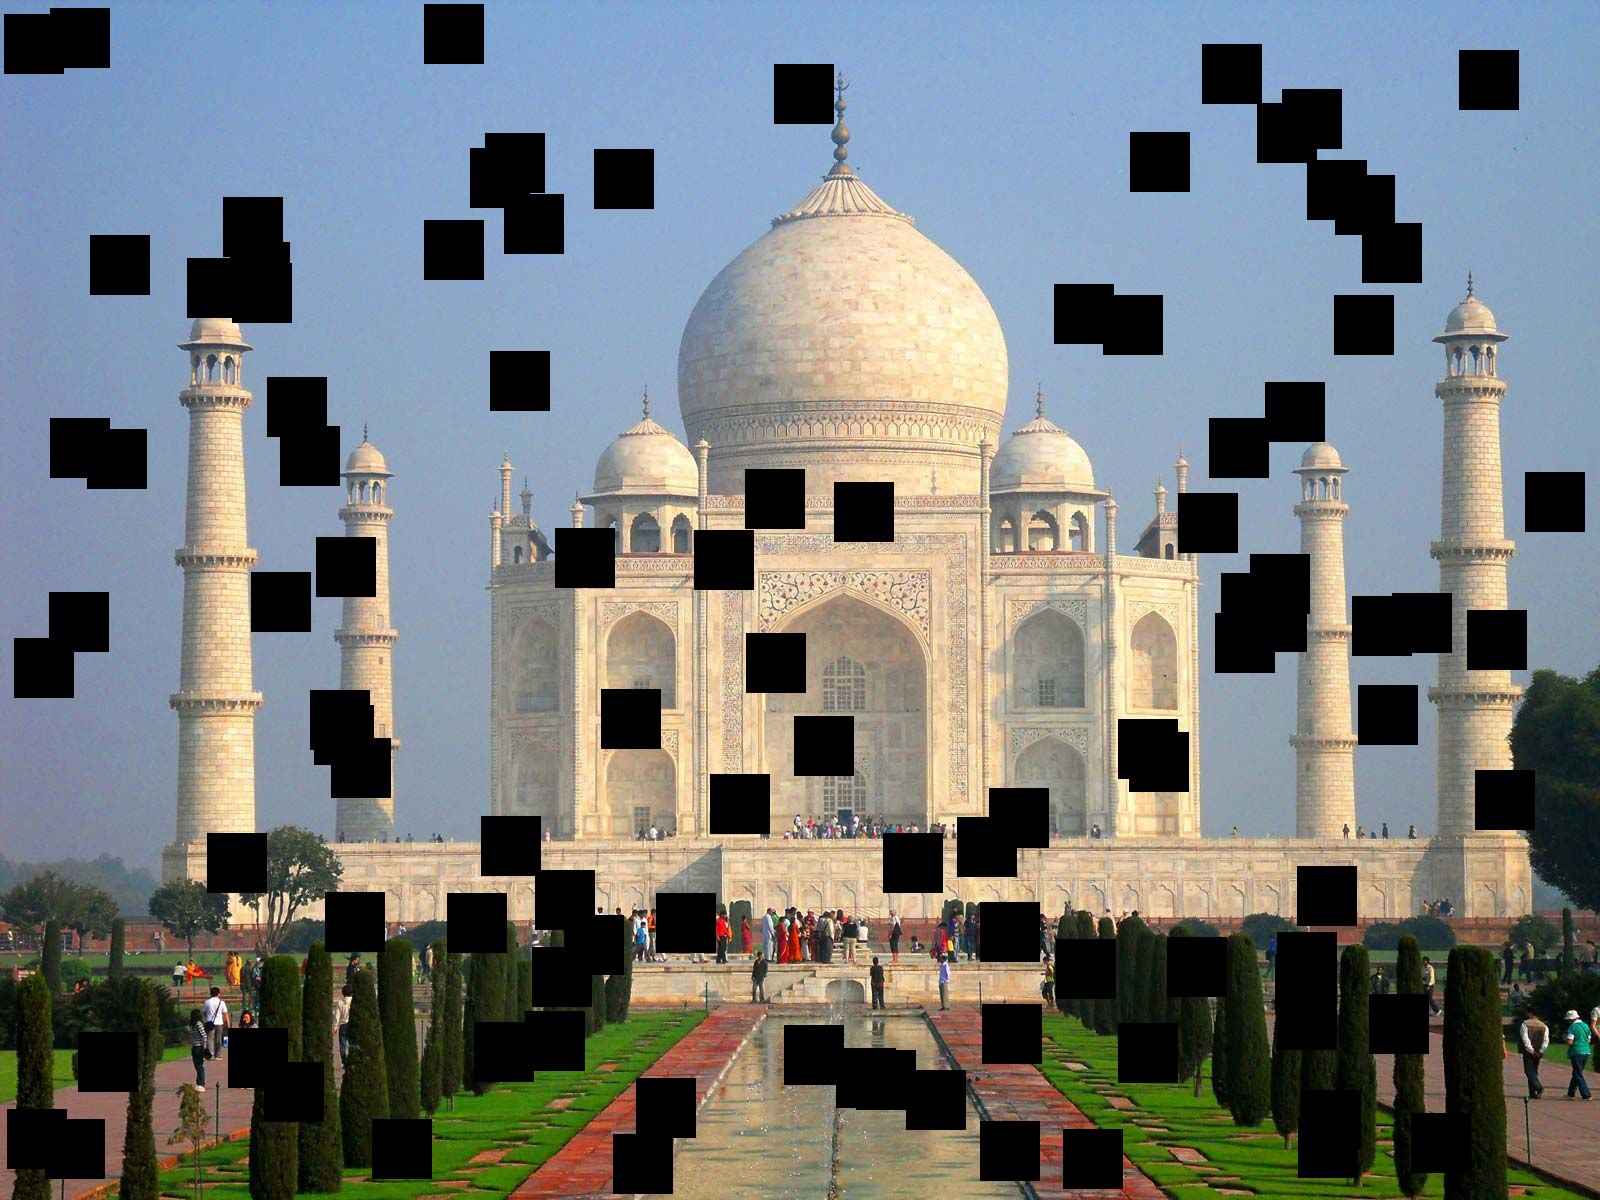

In [11]:
from PIL import Image, ImageFile
from matplotlib.pyplot import imshow
import requests
from io import BytesIO

%matplotlib inline


def add_noise(a):
    a2 = a.copy()
    rows = a2.shape[0]
    cols = a2.shape[1]
    s = int(min(rows,cols)/20) # size of spot is 1/20 of smallest dimension
    
    for i in range(100):
        x = np.random.randint(cols-s)
        y = np.random.randint(rows-s)
        a2[y:(y+s),x:(x+s)] = 0
        
    return a2

url = "https://cdn.britannica.com/33/178633-050-EDF93EA2/Taj-Mahal-Agra-Uttar-Pradesh-India.jpg"

response = requests.get(url,headers={'User-Agent': 'Mozilla/5.0'})
img = Image.open(BytesIO(response.content))
img.load()

img_array = np.asarray(img)
rows = img_array.shape[0]
cols = img_array.shape[1]

print("Rows: {}, Cols: {}".format(rows,cols))

# Create new image
img2_array = img_array.astype(np.uint8)
print(img2_array.shape)
img2_array = add_noise(img2_array)
img2 = Image.fromarray(img2_array, 'RGB')
img2        
        

### Preprocessing Many Images

First, we define several paths. We will download sample images of paperclips from **DOWNLOAD_SOURCE** URL and unzip them.  We will then perform the preprocessing on these paper clips.  I mean for this code as a starting point for other image preprocessing.

In [24]:
import os
#DOWNLOAD_SOURCE = "https://github.com/jeffheaton/data-mirror/releases/download/v1/iris-image.zip"
source = "https://github.com/jeffheaton/data-mirror/releases/download/v1/paperclips.zip"
name = DOWNLOAD_SOURCE[DOWNLOAD_SOURCE.rfind('/')+1:]
if COLAB:
    PATH = "/content"
    EXTRACT_TARGET = os.path.join(PATH,"clips")
    SOURCE = os.path.join(PATH, "/content/clips/paperclips")
    TARGET = os.path.join(PATH,"/content/clips-processed")
else:
    PATH = "/Users/Kushal Raj Sharma/Folder"
    EXTRACT_TARGET = os.path.join(PATH, "clips")
    SOURCE = os.path.join(PATH, "clips/paperclips")
    TARGET = os.path.join(PATH, "clips-processed")

EXTRACT_TARGET, SOURCE, TARGET

('/Users/Kushal Raj Sharma/Folder\\clips',
 '/Users/Kushal Raj Sharma/Folder\\clips/paperclips',
 '/Users/Kushal Raj Sharma/Folder\\clips-processed')

Next, we download the images. This part depends on the origin of your images. The following code downloads images from a URL, where a ZIP file contains the images. The code unzips the ZIP file.

# This ONWARDS perfectly works on GOOGLE COLLAB